- By: Alex Kwon
- Reference: Online Portfolio Selection by Dr. Bin Li and Dr. Steven Hoi
https://www.cis.upenn.edu/~mkearns/finread/portfolio.pdf

# Online Portfolio Selection: Exponential Gradient

## Abstract

Momentum strategies have been a popular quantitative strategy in recent decades as the simple but powerful trend following allows investors to exponentially increase their returns.

In this notebook, we will dive into Exponential Gradient, one of the methods for momentum. EG focuses on the best performing asset of the last time period

The package and module behind this implementation of OLPS is currently in the works and will be published on MlFinLab soon, so make sure to keep an eye out on that!

**1. Exponential Gradient**
    - Multiplicative Update
    - Gradient Projection
    - Expectation Maximization

# Strategy

Throughout the next couple weeks, we will be releasing notebooks on the following strategies

**Benchmarks** (Insert Link Here)
- Buy and Hold
- Best Stock
- Constant Rebalanced Portfolio
- Best Constant Rebalanced Portfolio

**Momentum**
- Exponential Gradient
- Follow the Leader
- Follow the Regularized Leader

**Mean Reversion**
- Anti-Correlation
- Passive Aggressive Mean Reversion
- Online Moving Average Reversion
- Robust Median Mean Reversion

**Pattern Matching**
- Nonparametric Histogram/Kernel-Based/Nearest Neighbor Log-Optimal
- Correlation Driven Nonparametric Learning
- Nonparametric Kernel-Based Semi-Log-Optimal/Markowitz/GV

**Meta Algorithm**
- Aggregating Algorithm
- Fast Universalization Algorithm
- Online Gradient Updates
- Online Newton Updates
- Follow the Leading History

**Universal Portfolio**
- Universal Portfolio
- CORN-U
- CORN-K
- SCORN-K
- FCORN-K

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlfinlab.online_portfolio_selection import *



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

## Import Data

We will use the ETF data included in the mlfinlab library for analysis. This includes 23 ETF's with closing prices from 2008 to 2016

In [3]:
stock_prices = pd.read_csv('../../mlfinlab/mlfinlab/tests/test_data/stock_prices.csv', parse_dates=True, index_col='Date')
stock_prices = stock_prices.dropna(axis=1)

In [4]:
stock_prices.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001,87.629997,37.939999,47.759998,41.299999,79.500000,...,42.090000,51.173328,55.983330,74.529999,67.309998,144.929993,94.379997,77.360001,101.400002,130.630005
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998,87.809998,37.919998,48.060001,42.049999,80.440002,...,42.029999,51.293331,55.599998,74.800003,67.500000,144.860001,94.250000,77.459999,101.519997,130.740005
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000,88.040001,36.990002,46.919998,40.779999,77.500000,...,42.349998,49.849998,54.536671,72.980003,65.769997,141.309998,94.269997,77.550003,101.650002,128.169998
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002,88.199997,37.259998,47.060001,40.220001,77.199997,...,43.230000,50.416672,56.116669,72.949997,65.650002,141.190002,94.680000,77.570000,101.720001,128.059998
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001,88.389999,36.970001,46.400002,39.599998,75.849998,...,43.240002,49.566669,55.326672,72.400002,65.360001,138.910004,94.570000,77.650002,101.739998,125.849998


## Momentum

Momentum strategies are implemented with the belief that the price changes from the previous period will continue.

## 1. Exponential Gradient

Exponential Gradient strategies focus on the following optimization problem that tracks the best performing stock with a learning rate, $\eta$, but also regularizes the new portfolio weight to prevent drastic changes from the previous portfolio.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \: \eta \log b \cdot x_t - R(b,b_t)$

### 1.1 Multiplicative Update 

Helmbold proposed a regularization term that adopts relative entropy.

$R(b,b_t) = \overset{m}{\underset{i=1}{\sum}}b_i \log \frac{b_i}{b_{t,i}}$

    
Using log's first order taylor expansion of $b_i$

$\log b \cdot x_t \approx \log(b_t \cdot x_t) + \frac{x_t}{b_t \cdot x_t}(b-b_t)$

Then a multiplicative update algorithm can be stated as the following
    
$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right)$

If we adopt relative entropy as the regularization factor, we can use log's first order taylor expansion to create an update rule to be the following multiplicative one.

$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right) / Z$, where $Z$ is a normalization term to sum the weights to 1

### 1.2 Gradient Projection

Instead of relative entropy, gradient projection adopts an L2-regularization term for the optimization equation.

$R(b,b_t) = \frac{1}{2}\overset{m}{\underset{i=1}{\sum}}(b_i - b_{t,i})^2$

This regularization term can be transcribed to the following update rule

$b_{t+1} = b_t + \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - \frac{1}{m} \sum_{j=1}^{m} \frac{x_t}{b_t \cdot x_t} \right)$

### 1.3 Expectation Maximization

Expectation Maximization uses a $\chi^2$ regularization term

$R(b-b_t)=\frac{1}{2}\overset{m}{\underset{i=1}{\sum}}\frac{(b_i - b_{t,i})^2}{b_{t,i}}$

Then, the corresponding update rule becomes

$b_{t+1} = b_t \cdot \left( \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - 1 \right) + 1 \right)$

Each of these update rules can be called using the **EG()** with different update rules with the default being multiplciative updates. Learning rates can also be adjusted by setting **eta**, and if no values are stated default will be 0.05

- Multiplicative Update: EG('MU')
- Gradient Projection: EG('GP')
- Expectation Maximization: EG('EM')

In [12]:
multiplicative_update_005 = EG(eta=0.05,update_rule='MU')
gradient_projection_005 = EG(eta=0.05,update_rule='GP')
expectation_maximization_005 = EG(eta=0.05,update_rule='GP')
multiplicative_update_005.allocate(stock_prices)
gradient_projection_005.allocate(stock_prices)
expectation_maximization_005.allocate(stock_prices)

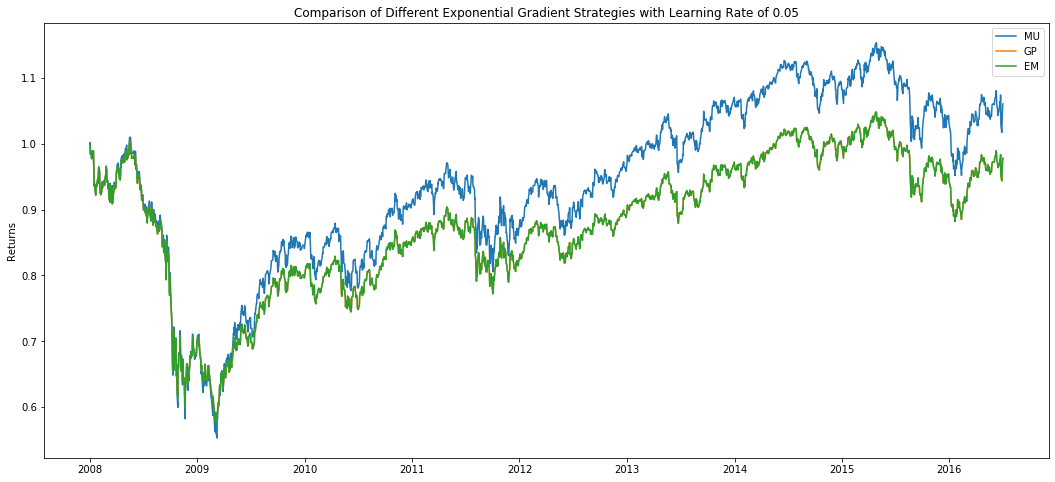

In [13]:
plt.figure(figsize=(18,8));
plt.plot(multiplicative_update_005.portfolio_return, label = 'MU');
plt.plot(gradient_projection_005.portfolio_return, label = 'GP');
plt.plot(expectation_maximization_005.portfolio_return, label = 'EM');
plt.title('Comparison of Different Exponential Gradient Strategies with Learning Rate of 0.05')
plt.ylabel('Returns')
plt.legend();

Interestingly, the gradient projection method and expectation maximization method return an identical graph, so the orange graph that represents GP cannot be seen.

The returns for the EG strategies are still disappointing, so we will look to increase the learning rate for our EG strategy.

In [14]:
new_multiplicative_update = EG(eta=0.5,update_rule='MU')
new_gradient_projection = EG(eta=0.5,update_rule='GP')
new_expectation_maximization = EG(eta=0.5,update_rule='GP')
new_multiplicative_update.allocate(stock_prices)
new_gradient_projection.allocate(stock_prices)
new_expectation_maximization.allocate(stock_prices)

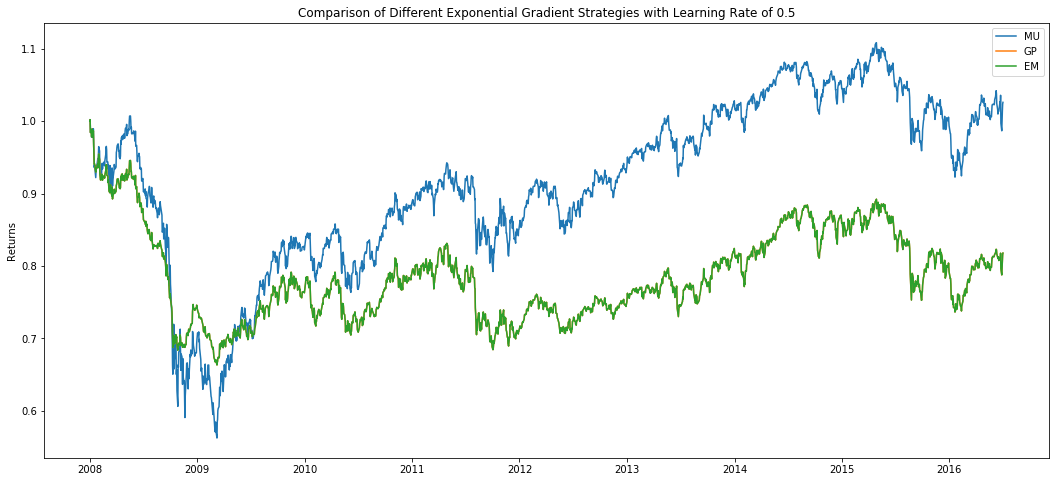

In [15]:
plt.figure(figsize=(18,8));
plt.plot(new_multiplicative_update.portfolio_return, label = 'MU');
plt.plot(new_gradient_projection.portfolio_return, label = 'GP');
plt.plot(new_expectation_maximization.portfolio_return, label = 'EM');
plt.title('Comparison of Different Exponential Gradient Strategies with Learning Rate of 0.5')
plt.ylabel('Returns')
plt.legend();

From the initial analysis, multiplicative update rules continue to return better returns than the other two methods. However, overall the returns are still disappointing as we continue to stay at almost original portfolio value.

We wil now examine how the learning rate affects the EG strategy for the multiplicative update method.

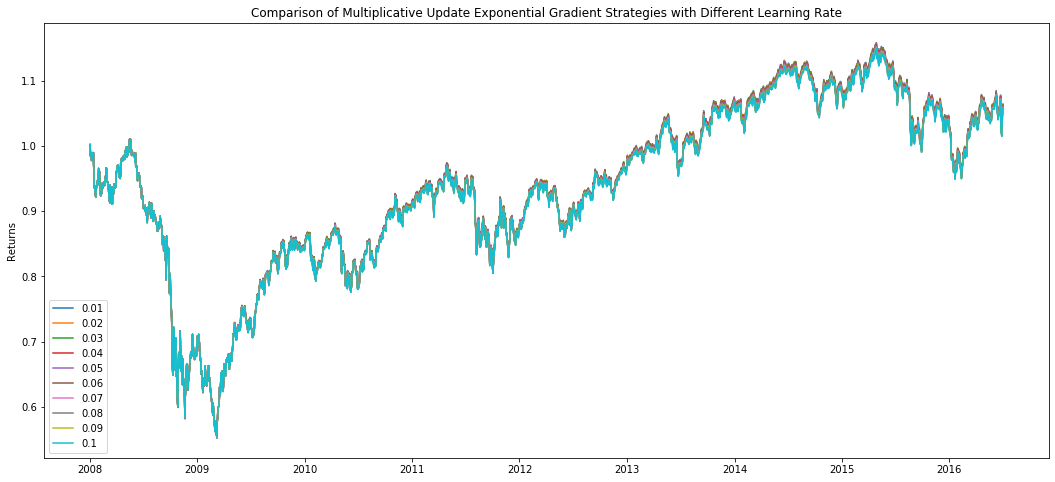

In [16]:
plt.figure(figsize=(18,8));
eta_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1]
for e in eta_values:
    strat = EG(eta=e, update_rule='MU')
    strat.allocate(stock_prices)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Comparison of Multiplicative Update Exponential Gradient Strategies with Different Learning Rate')
plt.ylabel('Returns')
plt.legend();

$\eta$ values of 0.01 to 0.1 seem to provide almost identical returns

Lets try to use a more sparse $\eta$ from 0.1 to 0.9.

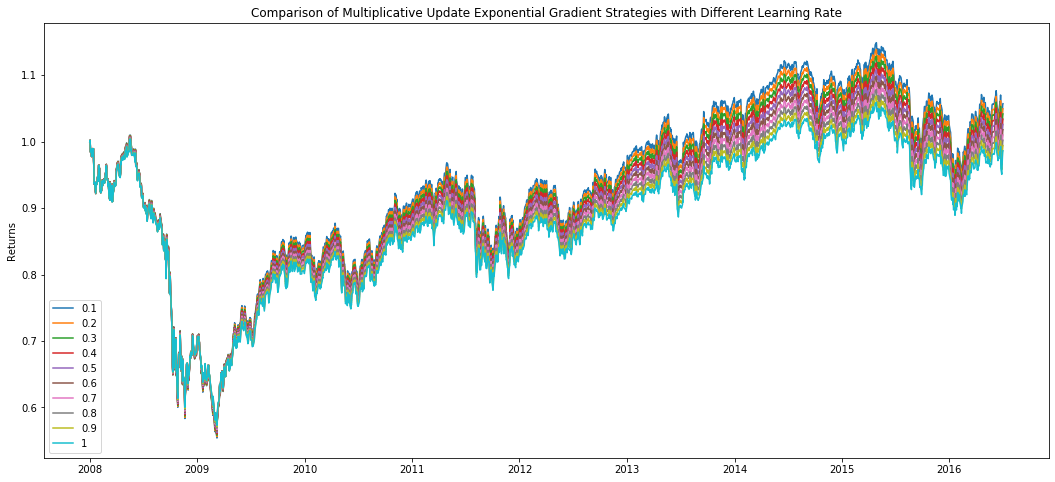

In [17]:
plt.figure(figsize=(18,8));
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
for e in eta_values:
    strat = EG(eta=e, update_rule='MU')
    strat.allocate(stock_prices)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Comparison of Multiplicative Update Exponential Gradient Strategies with Different Learning Rate')
plt.ylabel('Returns')
plt.legend();

$\eta$ value for 0.1 to 1 is very similar to the one above. There isn't much difference for the portfolio.

What happens if we move our $\eta$ to a value greater than 1?

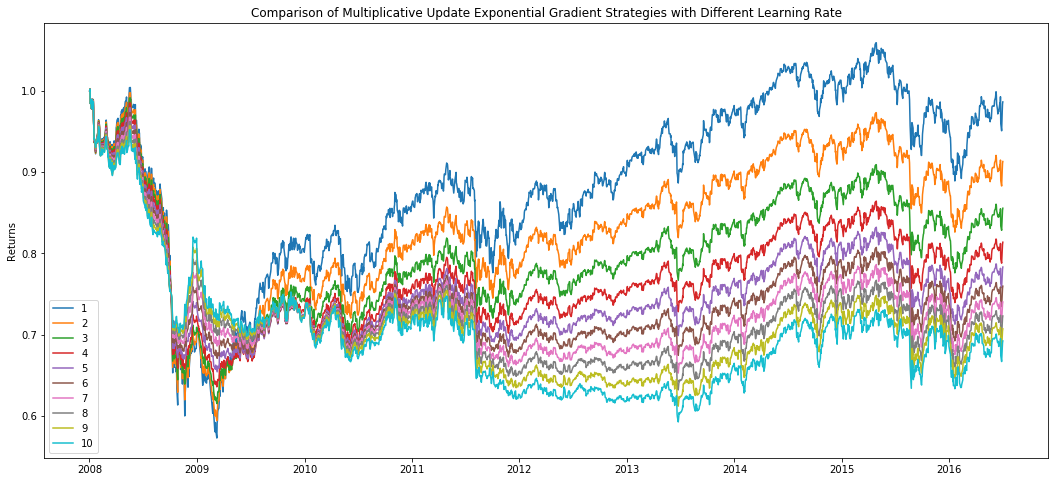

In [18]:
plt.figure(figsize=(18,8));
eta_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]
for e in eta_values:
    strat = EG(eta=e, update_rule='MU')
    strat.allocate(stock_prices)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Comparison of Multiplicative Update Exponential Gradient Strategies with Different Learning Rate')
plt.ylabel('Returns')
plt.legend();

At least from this data set, a higher $\eta$ makes the returns worse. Presumably as blindly performing the best performing asset the day before might not be the best strategy. There are other quantitative strategies that directly contrast momentum such as mean reversion that would offset the day's gains.

On another note, we will examine the possibility of resampling our data on a yearly basis

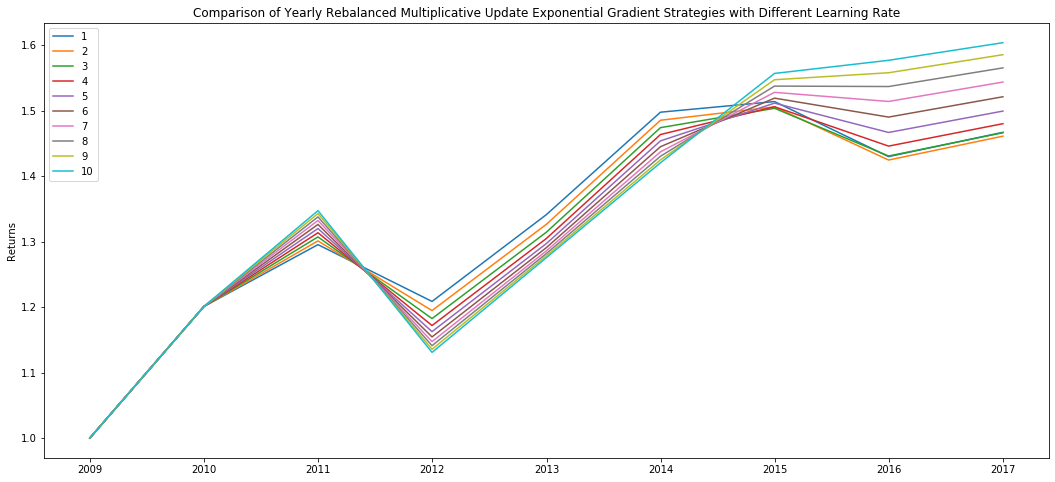

In [15]:
plt.figure(figsize=(18,8));
eta_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]
for e in eta_values:
    strat = EG(eta=e, update_rule='MU')
    strat.allocate(stock_prices, resample_by='Y')
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Comparison of Yearly Rebalanced Multiplicative Update Exponential Gradient Strategies with Different Learning Rate')
plt.ylabel('Returns')
plt.legend();

Yearly rebalancing actually gives a much higher return than the daily ones. This could be explained to the fact that this algorithm now attempts to capture the most value of the asset in the long run instead of looking at short term movements.

## Conclusion

Through this notebook, we were able to explore the basic functionalities of MlFinLab's newest Online Portfolio Selection module. Readers were exposed to a basic introduction to the exponential gradient strategy and will be able to replicate results using the simple methods of the new module.

The next notebook will focus on Momentum strategy called Follow the Leader.

If you enjoyed reading this please remember to leave us a star on GitHub and always let us know how to improve our modules!

:)